In [4]:
import pandas as pd
import numpy as np

Error parsing backtester output: [Errno 2] No such file or directory: 'C:\\Users\\ramon\\OneDrive\\Desktop\\Python projects\\Trading\\Prosperity 3\\round1\\backtests\\Logfile_OUR_DATA.log'
Market Data (Activities log) head:
   day  timestamp           product  bid_price_1  bid_volume_1  bid_price_2  \
0    0          0  RAINFOREST_RESIN         9998             1       9995.0   
1    0          0              KELP         2028            30          NaN   
2    0        100              KELP         2030             4       2028.0   
3    0        100  RAINFOREST_RESIN         9996             1       9995.0   
4    0        200  RAINFOREST_RESIN         9996             1       9995.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0          30.0          NaN           NaN        10005            30   
1           NaN          NaN           NaN         2032            30   
2          31.0          NaN           NaN         2032            31   
3        

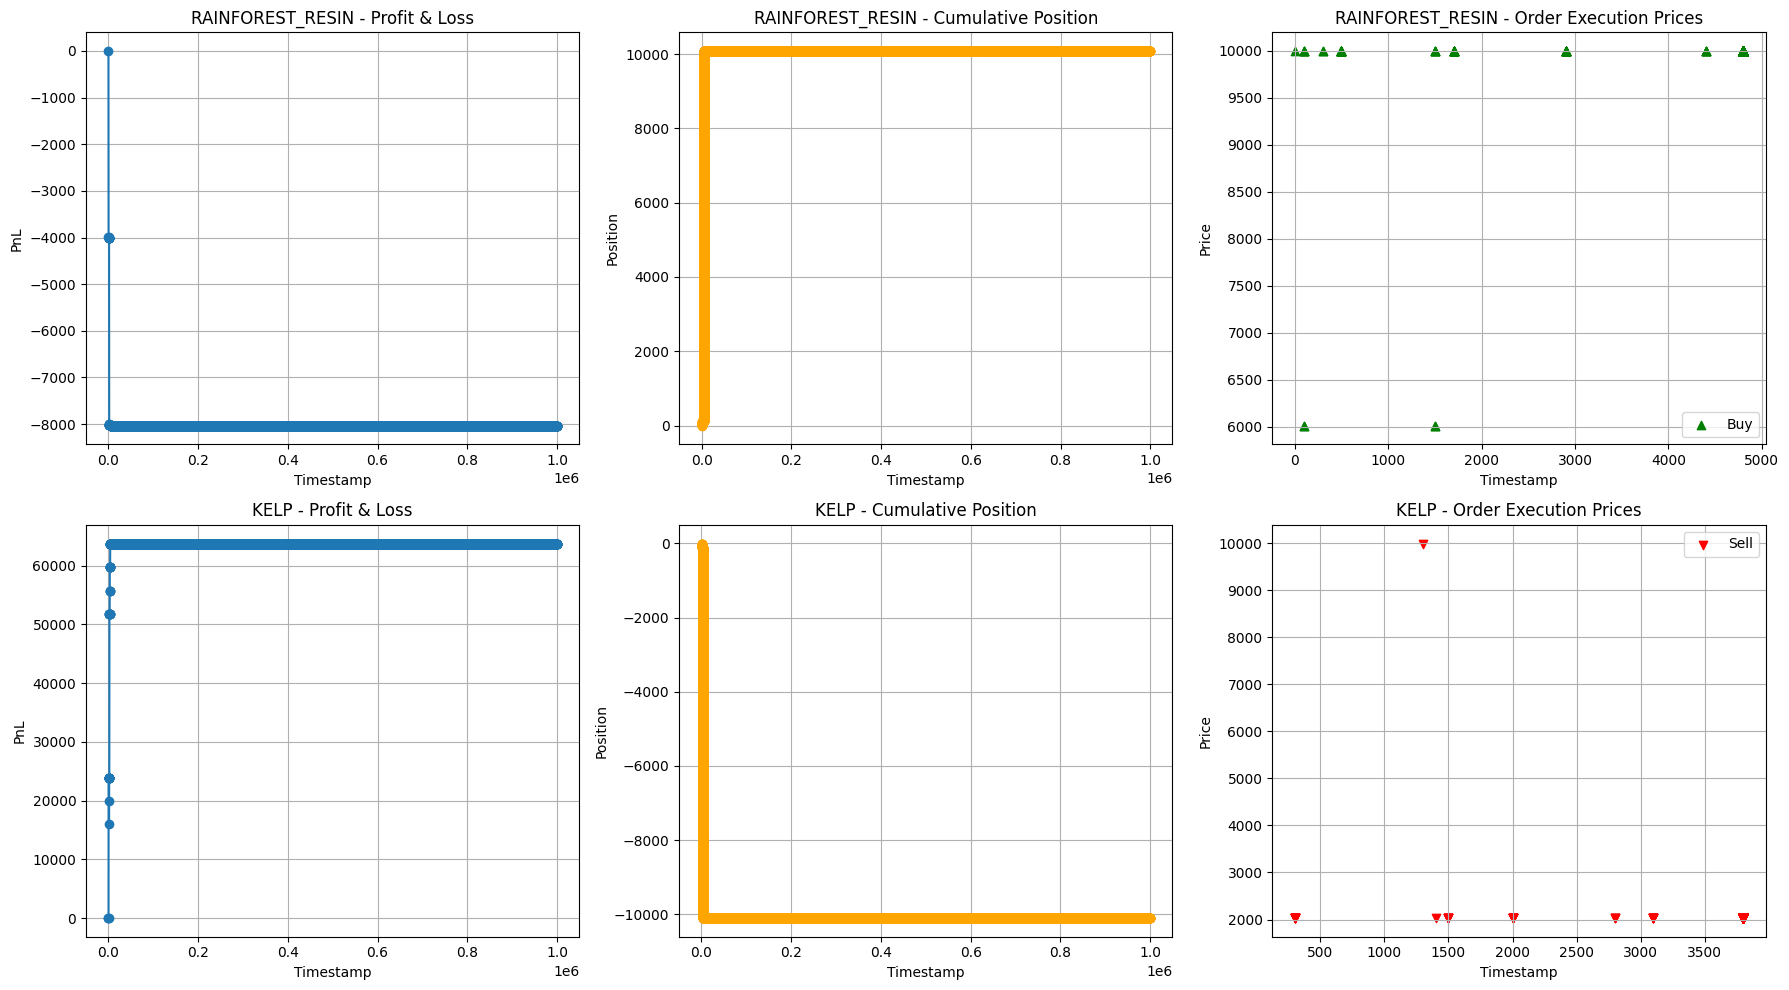

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import io

def parse_backtester_output(file_path):
    """
    Parses the backtester output file into a market data DataFrame and a trade history list.
    
    The output file is expected to contain three sections:
      - Sandbox logs (ignored)
      - Activities log: a CSV section starting with the header line after "Activities log:"
      - Trade History: a JSON array starting after "Trade History:"
    
    Parameters:
      file_path (str): Path to the backtester output file.
    
    Returns:
      market_data (pd.DataFrame): The activities log parsed into a DataFrame.
      trades (list): The trade history parsed as a list of dictionaries.
    """
    with open(file_path, "r") as f:
        content = f.read()
    
    # Split sections based on markers
    # We use the markers "Activities log:" and "Trade History:" as delimiters.
    # First, split off sandbox logs.
    parts = content.split("Activities log:")
    if len(parts) < 2:
        raise ValueError("Activities log section not found.")
    # The second part has CSV + other sections; now split the CSV and trade history.
    activities_and_rest = parts[1]
    activities_part, *rest = activities_and_rest.split("Trade History:")
    if not rest:
        raise ValueError("Trade History section not found.")
    trade_history_part = rest[0]
    
    # The Activities log portion is in CSV format.
    # Sometimes there might be leading/trailing whitespace or extra newlines.
    csv_text = activities_part.strip()
    # Read CSV using semicolon as delimiter.
    market_data = pd.read_csv(io.StringIO(csv_text), delimiter=";")
    
    # The Trade History portion is a JSON array.
    trade_history_text = trade_history_part.strip()
    # In case there are extra characters before/after the JSON (e.g. newlines), try to extract the JSON starting with '[':
    json_start = trade_history_text.find('[')
    if json_start == -1:
        raise ValueError("JSON start '[' not found in Trade History section.")
    json_text = trade_history_text[json_start:]
    trades = json.loads(json_text)
    
    return market_data, trades

def plot_metrics(market_data: pd.DataFrame, trades: list):
    """
    Graph metrics for each product using market data and trade history.
    
    This function creates three subplots per product:
      1) Profit & Loss (PnL) over time.
      2) Cumulative position computed from the trade history.
      3) Trade execution prices, marking buys and sells.
    
    Parameters:
      market_data: DataFrame containing at least the following columns:
                   - 'timestamp': time of the market snapshot.
                   - 'product': product identifier.
                   - 'profit_and_loss': PnL at that snapshot.
      trades: List of trade dictionaries, each with keys:
              'timestamp', 'buyer', 'seller', 'symbol' (product), 'price', 'quantity'.
    """
    
    # Sort the market data by timestamp.
    market_data = market_data.sort_values('timestamp')
    
    # Extract the unique products (assumed to be in the 'product' column)
    products = market_data['product'].unique()
    n_products = len(products)
    
    # Create a figure with one row per product and three columns for each subplot.
    fig, axs = plt.subplots(n_products, 3, figsize=(18, 5 * n_products), squeeze=False)
    
    # Convert the trade list into a DataFrame and sort by timestamp.
    trades_df = pd.DataFrame(trades)
    trades_df.sort_values('timestamp', inplace=True)
    
    for i, product in enumerate(products):
        # Filter market_data and trades for the current product.
        prod_market = market_data[market_data['product'] == product]
        prod_trades = trades_df[trades_df['symbol'] == product].copy()
        
        # --- PnL Plot ---
        ax = axs[i][0]
        ax.plot(prod_market['timestamp'], prod_market['profit_and_loss'], marker='o', linestyle='-')
        ax.set_title(f"{product} - Profit & Loss")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("PnL")
        ax.grid(True)
        
        # --- Cumulative Position Plot ---
        # We compute the position change based on trades.
        # We assume that when your algorithm is the buyer (with "SUBMISSION" on seller),
        # the position increases, and when it is the seller (with "SUBMISSION" on buyer), it decreases.
        def position_change(row):
            if row['seller'] == "SUBMISSION":
                return row['quantity']
            elif row['buyer'] == "SUBMISSION":
                return -row['quantity']
            else:
                return 0
        
        if not prod_trades.empty:
            prod_trades['position_change'] = prod_trades.apply(position_change, axis=1)
            prod_trades['cumulative_position'] = prod_trades['position_change'].cumsum()
        else:
            # If no trades exist for this product, create a dummy timeline with zero positions.
            prod_trades = pd.DataFrame({
                'timestamp': prod_market['timestamp'],
                'cumulative_position': 0
            })

        ax = axs[i][1]
        ax.plot(prod_trades['timestamp'], prod_trades['cumulative_position'], marker='o', linestyle='-', color='orange')
        ax.set_title(f"{product} - Cumulative Position")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Position")
        ax.grid(True)
        
        # --- Order / Trade Prices Plot ---
        # Separate the trade markers into buys and sells.
        buys = prod_trades[prod_trades['position_change'] > 0]
        sells = prod_trades[prod_trades['position_change'] < 0]

        ax = axs[i][2]
        if not buys.empty:
            ax.scatter(buys['timestamp'], buys['price'], marker='^', color='green', label="Buy")
        if not sells.empty:
            ax.scatter(sells['timestamp'], sells['price'], marker='v', color='red', label="Sell")
        ax.set_title(f"{product} - Order Execution Prices")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Price")
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Adjust the file path below to your backtester output file.
    output_file = r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\backtests\Logfile_OUR_DATA.log"
    #output_file = r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\Last year\logfile.log"
    
    try:
        market_data, trades = parse_backtester_output(output_file)
    except Exception as e:
        print("Error parsing backtester output:", e)
        exit(1)
    
    # Optional: display first few rows of each DataFrame for verification
    print("Market Data (Activities log) head:")
    print(market_data.head())
    print("\nTrade History head:")
    print(pd.DataFrame(trades).head())
    
    plot_metrics(market_data, trades)


Market Data (Activities log) head:
   day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
0    0          0  AMETHYSTS         9998             1       9995.0   
1    0          0  STARFRUIT         5036            30          NaN   
2    0        100  AMETHYSTS         9996             1       9995.0   
3    0        100  STARFRUIT         5041             4       5037.0   
4    0        200  AMETHYSTS         9996             1       9995.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0          30.0          NaN           NaN        10005            30   
1           NaN          NaN           NaN         5043            30   
2          30.0          NaN           NaN        10002             6   
3           1.0       5036.0          30.0         5043            31   
4          21.0          NaN           NaN        10004             1   

   ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0          NaN         

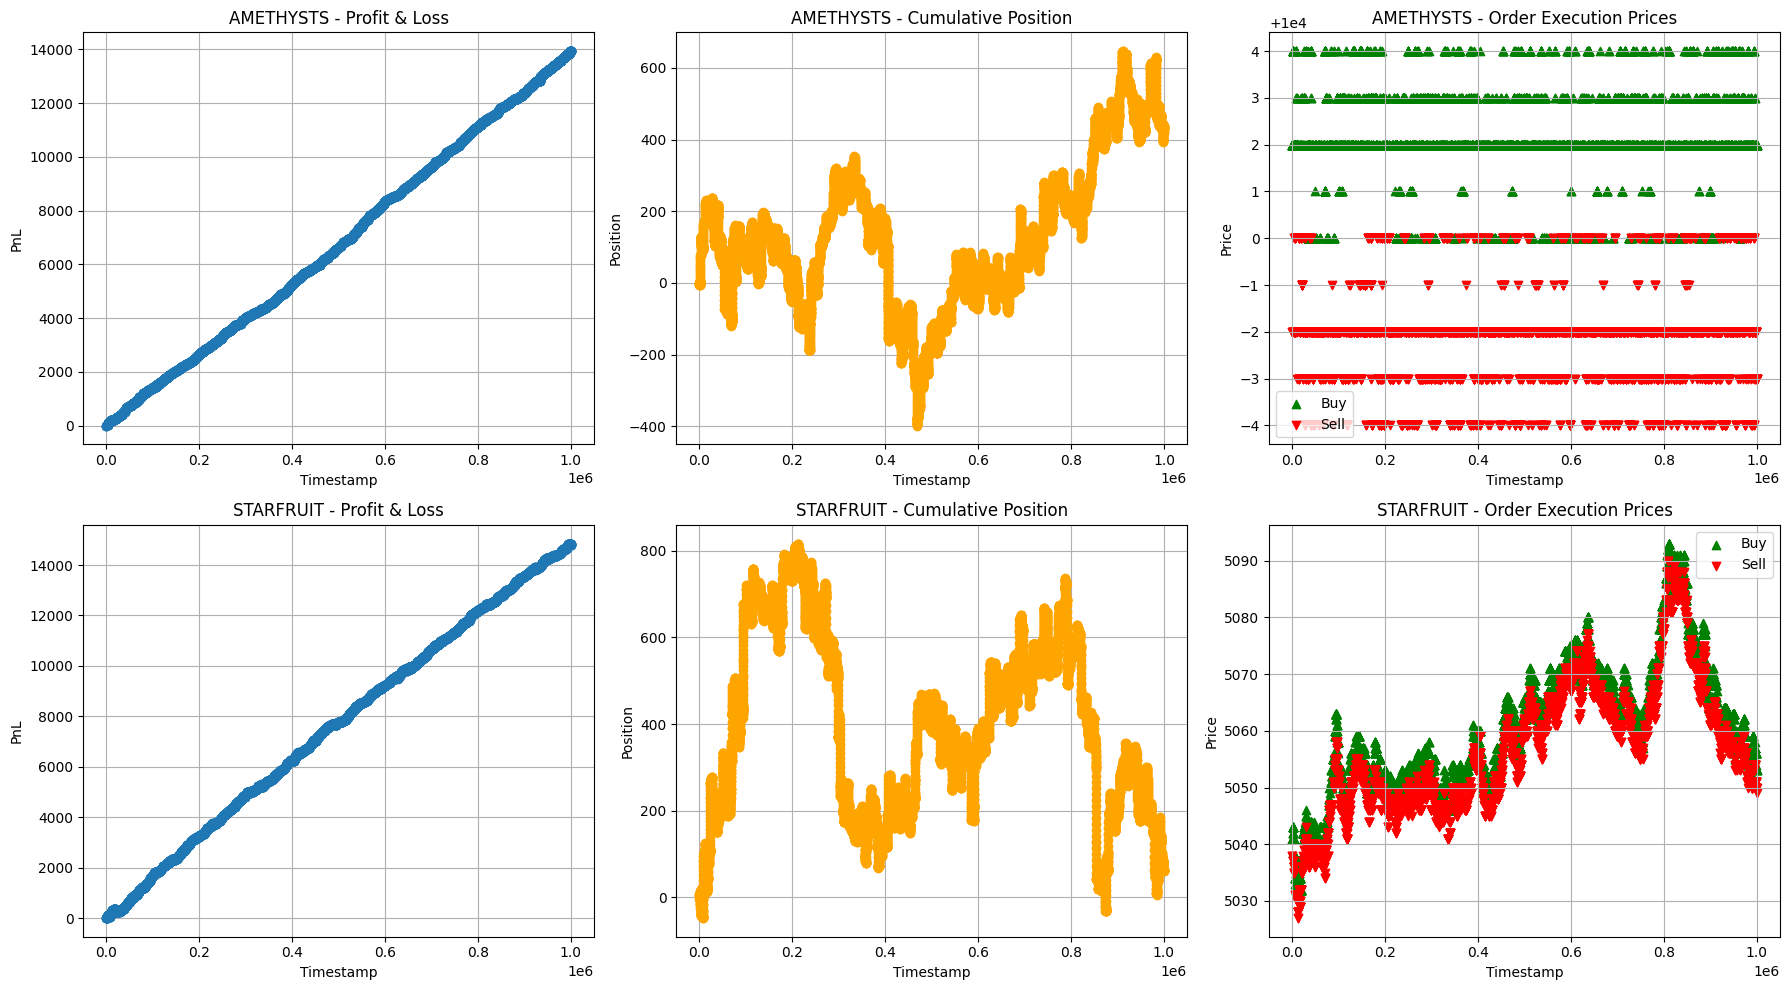

In [17]:
if __name__ == "__main__":
    # Adjust the file path below to your backtester output file.
    output_file = r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\backtests\Logfile_OUR_DATA.log"
    output_file = r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\Last year\logfile.log"
    
    try:
        market_data, trades = parse_backtester_output(output_file)
    except Exception as e:
        print("Error parsing backtester output:", e)
        exit(1)
    
    # Optional: display first few rows of each DataFrame for verification
    print("Market Data (Activities log) head:")
    print(market_data.head())
    print("\nTrade History head:")
    print(pd.DataFrame(trades).head())
    
    plot_metrics(market_data, trades)


In [11]:
import pandas as pd
import os

# Define la ruta base de los archivos
base_path = r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle"

# Listas para almacenar los DataFrames de cada día
all_market_data = []
all_trade_history = []

# Itera sobre los días que quieres leer
for day in range(-1, 2):  # El rango debe ser hasta 2 para incluir el día 1
    prices_file = os.path.join(base_path, f"prices_round_1_day_{day}.csv")
    trades_file = os.path.join(base_path, f"trades_round_1_day_{day}.csv")

    try:
        market_data = pd.read_csv(prices_file, sep=";", header=0)
        all_market_data.append(market_data)
    except FileNotFoundError:
        print(f"No se encontró el archivo: {prices_file}")

    try:
        trade_history = pd.read_csv(trades_file, sep=";", header=0)
        all_trade_history.append(trade_history)
    except FileNotFoundError:
        print(f"No se encontró el archivo: {trades_file}")

# Concatena todos los DataFrames en uno solo
market_data_ALL = pd.concat(all_market_data, ignore_index=True)
trade_history_ALL = pd.concat(all_trade_history, ignore_index=True)

# Guarda los DataFrames concatenados en archivos CSV
output_prices_file = os.path.join(base_path, "prices_round_1_ALL.csv")
output_trades_file = os.path.join(base_path, "trades_round_1_ALL.csv")

market_data_ALL.to_csv(output_prices_file, index=False)
trade_history_ALL.to_csv(output_trades_file, index=False)

print(f"Archivo de precios concatenado guardado en: {output_prices_file}")
print(f"Archivo de historial de trades concatenado guardado en: {output_trades_file}")

No se encontró el archivo: C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle\prices_round_1_day_1.csv
No se encontró el archivo: C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle\trades_round_1_day_1.csv
Archivo de precios concatenado guardado en: C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle\prices_round_1_ALL.csv
Archivo de historial de trades concatenado guardado en: C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle\trades_round_1_ALL.csv


In [10]:
market_data_ALL = pd.DataFrame()
trade_history_ALL = pd.DataFrame()
for day in range(-1,1):
    if market_data_ALL.shape[0] > 0:
        market_data = pd.read_csv(rf"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle\prices_round_1_day_{day}.csv", sep=";", header=0)
        trade_history = pd.read_csv(rf"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle\trades_round_1_day_{day}.csv", sep=";", header=0)

        market_data_ALL = market_data_ALL.concat(market_data)
        trade_history_ALL = trade_history_ALL.concat(trade_history)
    else:
        market_data_ALL = pd.read_csv(rf"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle\prices_round_1_day_{day}.csv", sep=";", header=0)
        trade_history_ALL = pd.read_csv(rf"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle\trades_round_1_day_{day}.csv", sep=";", header=0)

market_data_ALL.to_csv(r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle\prices_round_1_ALL.csv")
trade_history_ALL.to_csv(r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\Data\round-1-island-data-bottle\trades_round_1_ALL.csv")


AttributeError: 'DataFrame' object has no attribute 'concat'